## Gaussian Process Modeling on Single Metabolite 
### Author: Allen Ross
### Date: 01/18/2021

In [1]:
# Setup

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist

In [2]:
# Read in metabolomics data
mbx = pd.read_csv('../../hmp2/data/seq/ibdmdb/public/HMP2/Metabolites/1723/HMP2_metabolomics.csv')

# Read in metadata for timing of samples
meta = pd.read_csv('../../hmp2/data/hmp2_metadata.csv')

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Check data and pull off one metabolite for an exercise
mb = mbx.iloc[0,7:]
mb.head(10)

HSM5FZBJ    4.35547e+06
MSM5FZ9X    2.62384e+06
CSM5FZ3N         942546
ESM5MEDZ    5.75912e+06
MSM5FZA2    2.23142e+06
MSM5LLHZ         913814
HSM5FZBQ    1.97614e+06
MSM5LLIC    2.32295e+06
MSM5LLIG     1.3556e+06
CSM5FZ3T         470132
Name: 0, dtype: object

In [4]:
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mb.index)][['External ID', 'Participant ID', 'date_of_receipt']]
meta.set_index('External ID', inplace = True)

In [5]:
# Merge metabolomics info to metadata
df = (meta.merge(mb, left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date',
                        0: 'intensity'}))

# Fix the date column
df.date = pd.to_datetime(df.date)

In [6]:
# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Make sure that intensities are numeric
df.intensity = df.intensity.astype('double')

# Then calculate the log of the intensities
df['log_intensity'] = np.log(df.intensity)

# Finally standardize the log values
log_intensity_mean = df.log_intensity.mean()
log_intensity_sd = df.log_intensity.std()
df['scaled_log_intensity'] = (df.log_intensity - log_intensity_mean)/log_intensity_sd
df.head()

,id,date,intensity,days_from_start,log_intensity,scaled_log_intensity
CSM5FZ3N,C3001,2014-03-14,942546.0,93,13.756340,-0.409704
CSM5FZ3T,C3002,2014-04-29,470132.0,139,13.060769,-1.244306
CSM5FZ44,C3002,2014-06-24,720369.0,195,13.487519,-0.732257
CSM5FZ48,C3003,2014-05-08,1069292.0,148,13.882507,-0.258318
CSM5FZ4A,C3004,2014-05-13,1265301.0,153,14.050821,-0.056363


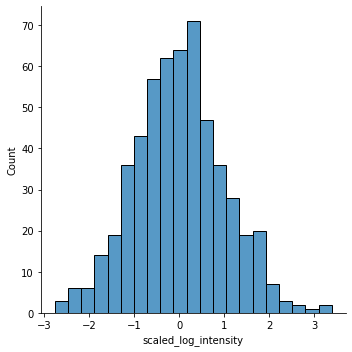

In [7]:
# Plot scaled transformed data
sns.displot(data = df,
            x = 'scaled_log_intensity');

In [8]:
df.head()

,id,date,intensity,days_from_start,log_intensity,scaled_log_intensity
CSM5FZ3N,C3001,2014-03-14,942546.0,93,13.756340,-0.409704
CSM5FZ3T,C3002,2014-04-29,470132.0,139,13.060769,-1.244306
CSM5FZ44,C3002,2014-06-24,720369.0,195,13.487519,-0.732257
CSM5FZ48,C3003,2014-05-08,1069292.0,148,13.882507,-0.258318
CSM5FZ4A,C3004,2014-05-13,1265301.0,153,14.050821,-0.056363


In [9]:
df.dtypes

id                              object
date                    datetime64[ns]
intensity                      float64
days_from_start                  int64
log_intensity                  float64
scaled_log_intensity           float64
dtype: object

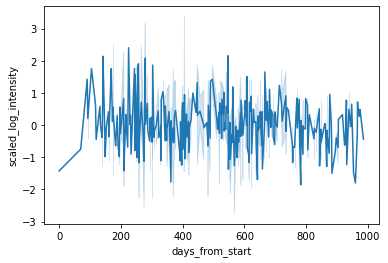

In [10]:
# Plot data
sns.lineplot(data = df,
             x = 'days_from_start',
             y = 'scaled_log_intensity');

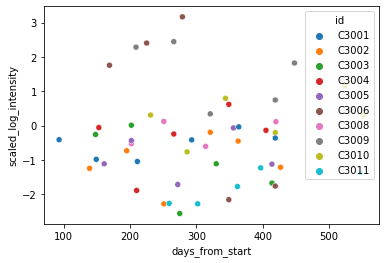

In [11]:
# Plot data for a subset
num_ids = 10
df_sub_id = df[df.id.isin(df.id.unique()[:num_ids])]
sns.scatterplot(data = df_sub_id,
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id');

In [12]:
# Modify data to creat dummies
df_sub = pd.get_dummies(df_sub_id[['id', 'days_from_start', 'scaled_log_intensity']])
df_sub.days_from_start = (df_sub.days_from_start - df_sub.days_from_start.mean())/df_sub.days_from_start.std()

In [14]:
# Specify simple model
with pm.Model() as model:
    
    # Exponential length hyperparameter prior
#     l_day = pm.Uniform('l_day', lower = 0, upper = 100)
#     l_day = pm.HalfCauchy('l_day', beta = 0.5)
    l_day = pm.Lognormal('l_day', mu = 0, sigma = 1)
    
    # Function variance prior
#     s2_f = pm.HalfCauchy('s2_f', beta = 0.5, shape = 4)
    s2_f = pm.Lognormal('s2_f', mu = 0, sigma = 1, shape = 4)
    
    # Linear covariance pattern prior
    c = pm.Normal('c', mu = 0, tau = 1)

    # Periodicity variance priors
#     period = pm.HalfNormal('period', tau = 0.5)
#     l_period = pm.HalfNormal('l_period', tau = 0.5)
    period = pm.Lognormal('period', mu = 0, sigma = 1)
    l_period = pm.Lognormal('l_period', mu = 0, sigma = 1)
    
    
    # Covariance over individuals
#     l_id = pm.HalfCauchy('l_id', beta = 0.5, shape = num_ids)
    l_id = pm.Lognormal('l_id', mu = 0, sigma = 1, shape = num_ids)

    # Function covariance equation
    f_cov = ((s2_f[0]*pm.gp.cov.ExpQuad(df_sub.shape[1]-1, l_day, active_dims = [0]) + 
             
             s2_f[1]*pm.gp.cov.Linear(df_sub.shape[1]-1, c, active_dims = [0]) + 
              
             s2_f[2]*pm.gp.cov.Periodic(df_sub.shape[1]-1, period = period, 
                                        ls = l_period, active_dims = [0])) * 
             
             s2_f[3]*pm.gp.cov.ExpQuad(df_sub.shape[1]-1, l_id, 
                                       active_dims = np.arange(num_ids)+1))
    
    # Specify GP marginal
    gp = pm.gp.Marginal(cov_func = f_cov)
    
    # Noise variance prior
#     s2_n = pm.HalfCauchy('s2_n', beta = 0.5)
    s2_n = pm.Lognormal('s2_n', mu = 0, sigma = 1)
    
    # List observed information
    y_obs = gp.marginal_likelihood('y_obs',
                                   noise=s2_n, 
#                                    X = df_sub.days_from_start[:, None],
                                   X = df_sub.drop(columns = ['scaled_log_intensity']).to_numpy(),
                                   y = df_sub.scaled_log_intensity[:, None].squeeze())

In [15]:
# Compute MAP
with model:
    mp = pm.find_MAP()

In [16]:
mp

{'l_day_log__': array(-0.7683157),
 's2_f_log__': array([-1.54753333, -0.43377453, -0.12290893, -0.10447526]),
 'c': array(0.22901775),
 'period_log__': array(0.46454013),
 'l_period_log__': array(-0.74123025),
 'l_id_log__': array([-0.92237988,  0.08488702,  0.46798071, -1.12322313, -0.00643518,
        -1.17394045, -1.00663401, -1.20823916, -0.69829236,  0.21867872]),
 's2_n_log__': array(-1.47328973),
 'l_day': array(0.46379358),
 's2_f': array([0.21277217, 0.64805836, 0.88434419, 0.90079708]),
 'period': array(1.59128224),
 'l_period': array(0.47652731),
 'l_id': array([0.39757174, 1.08859407, 1.5967666 , 0.32522984, 0.99358548,
        0.30914636, 0.365447  , 0.29872282, 0.49743402, 1.2444314 ]),
 's2_n': array(0.22917033)}

In [17]:
# Predict values across time, assume we are looking at the first id
# X_new = np.linspace(0, 1000, 200)[:, None]
X_new = np.vstack([np.linspace(-3, 3, 200), 
                 np.repeat(1, 200),
                 np.zeros(shape = (num_ids-1, 200))]).T

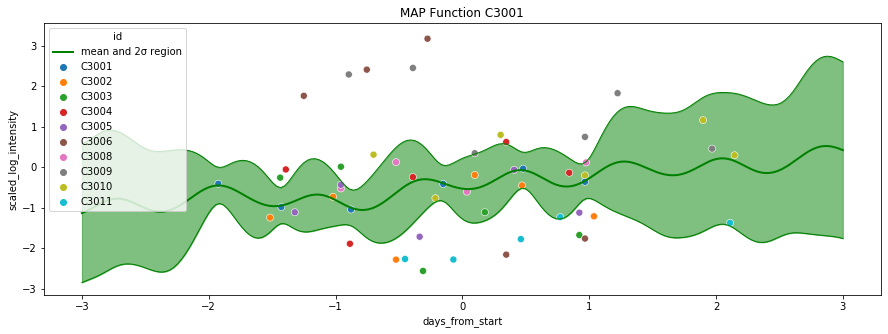

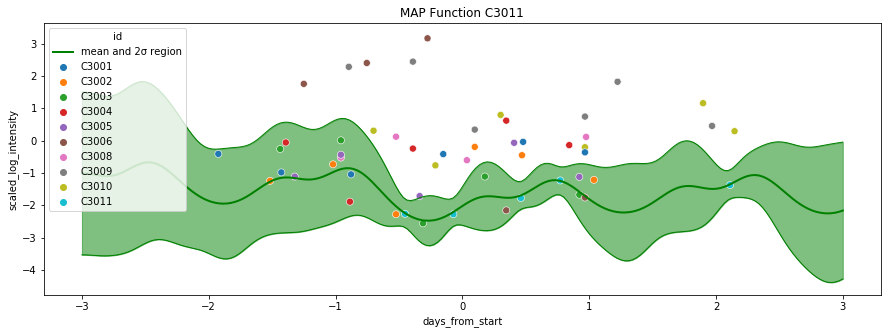

In [18]:
# Plot posterior from MAP 
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new[:,0], mu, "g", lw=2, label="mean and 2σ region")
plt.plot(X_new[:,0], mu + 2 * sd, "g", lw=1)
plt.plot(X_new[:,0], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new[:,0].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
plt.title('MAP Function C3001');
# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

X_new2 = np.vstack([np.linspace(-3, 3, 200), 
                    np.zeros(shape = (num_ids-1, 200)),
                    np.repeat(1, 200)]).T

# Plot posterior from MAP 
mu, var = gp.predict(X_new2, point=mp, diag=True)
sd = np.sqrt(var)

# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new[:,0], mu, "g", lw=2, label="mean and 2σ region")
plt.plot(X_new[:,0], mu + 2 * sd, "g", lw=1)
plt.plot(X_new[:,0], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new[:,0].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
plt.title('MAP Function C3011');
# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

In [19]:
# Sample from posterior
with model:
    trace = pm.sample(2000,
                      random_seed = 1,
                      target_accept = 0.95,
                      tune = 2000,
                      chains = 2,
                      cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s2_n, l_id, l_period, period, c, s2_f, l_day]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 690 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
pm.summary(trace)

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c,0.265,0.832,-1.319,1.823,0.019,0.015,1974.0,1486.0,1978.0,1979.0,1.0
l_day,1.414,2.310,0.041,4.496,0.062,0.044,1386.0,1386.0,1016.0,1188.0,1.0
s2_f[0],1.479,1.442,0.048,3.829,0.037,0.026,1505.0,1505.0,1161.0,1523.0,1.0
s2_f[1],0.704,0.649,0.033,1.803,0.014,0.010,2211.0,2211.0,1743.0,1265.0,1.0
s2_f[2],1.451,1.317,0.086,3.770,0.031,0.022,1786.0,1786.0,1850.0,2057.0,1.0
s2_f[3],0.647,0.425,0.096,1.407,0.011,0.008,1495.0,1495.0,1385.0,1756.0,1.0
period,1.790,1.941,0.042,4.755,0.047,0.034,1679.0,1679.0,664.0,441.0,1.0
l_period,1.653,2.132,0.035,4.741,0.045,0.032,2289.0,2289.0,1456.0,1879.0,1.0
l_id[0],2.283,2.445,0.049,6.165,0.052,0.036,2247.0,2247.0,1954.0,2023.0,1.0
l_id[1],2.738,2.695,0.057,7.395,0.070,0.051,1470.0,1412.0,1530.0,1367.0,1.0


/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


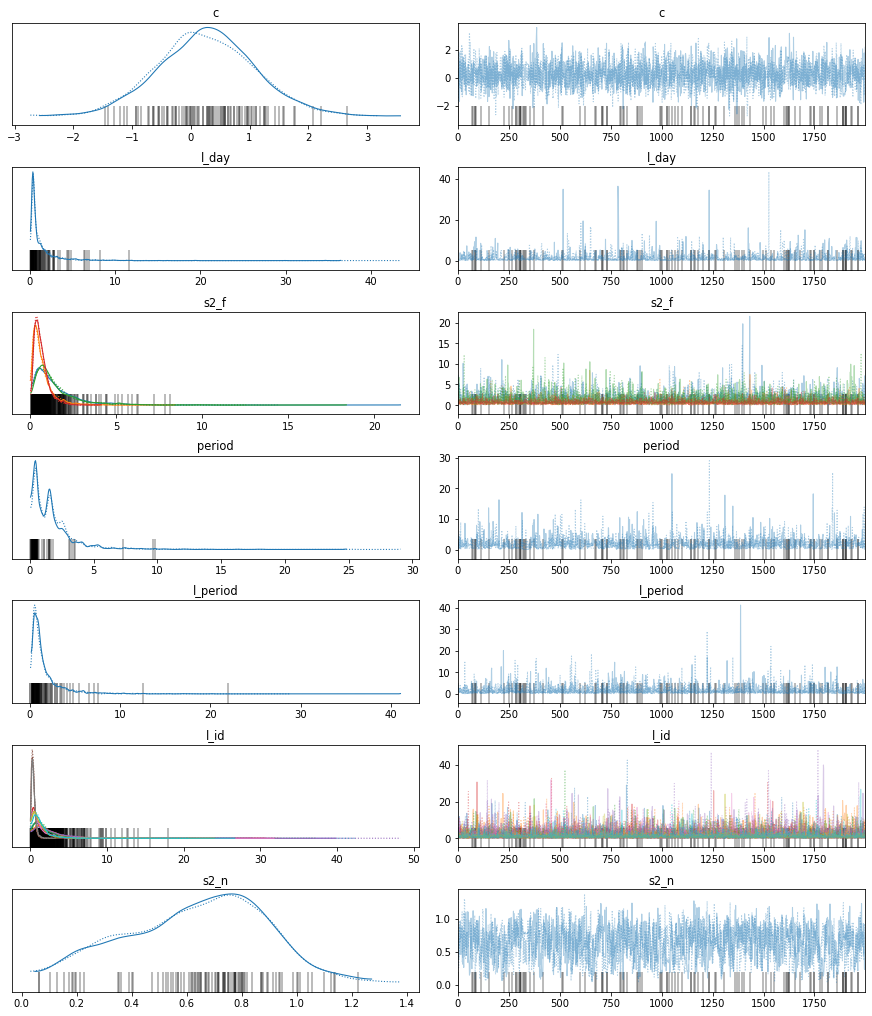

In [21]:
# Plot posterior
pm.traceplot(trace);

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


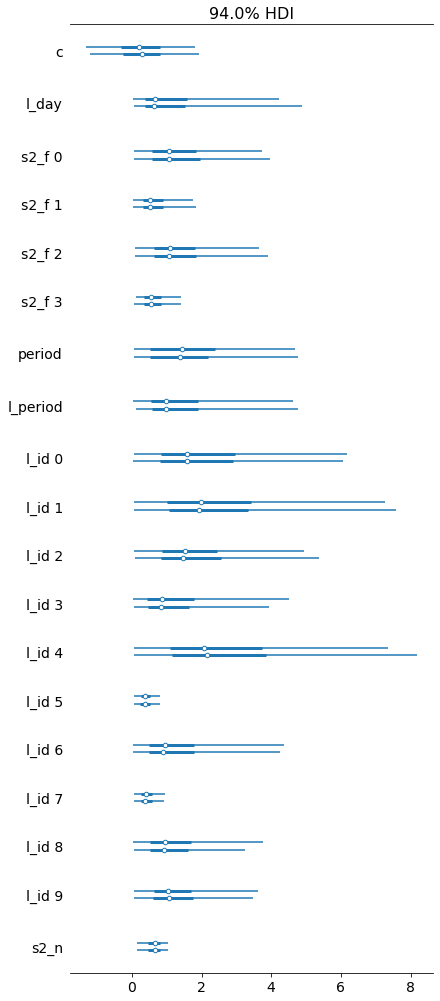

In [22]:
pm.forestplot(trace);

In [23]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    f_pred = gp.conditional('f_pred', X_new)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)

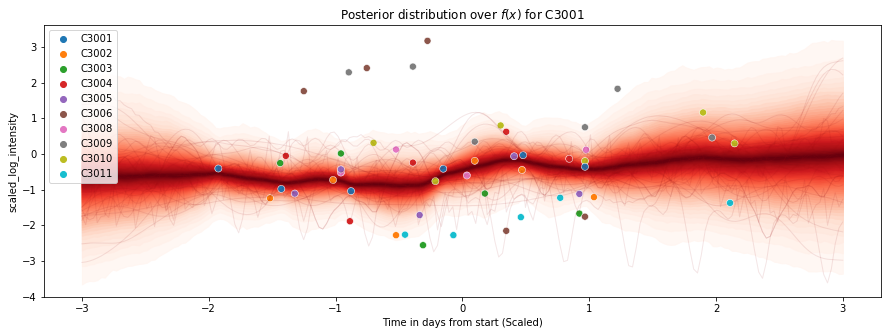

In [28]:
# Plotting 
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples["f_pred"], 
             X_new[:,0])

# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start (Scaled)")
# plt.ylim([-6, 6])
# plt.xlim([-4, 4])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();

In [25]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    y_pred = gp.conditional('y_pred', X_new, pred_noise = True)
    
    # Now get the predictive distribution
    y_samples = pm.sample_posterior_predictive(trace, 
                                                  var_names = ['y_pred'],
                                                  random_seed = 1)

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/scipy/stats/_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


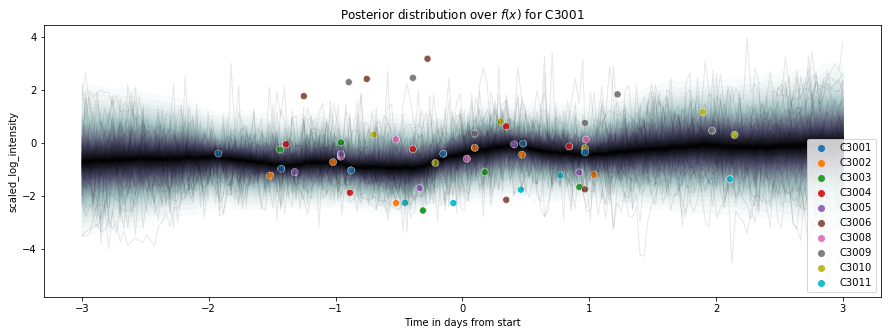

In [27]:
# Plotting PPD for observations (include noise)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             y_samples['y_pred'], 
             X_new[:,0],
             palette = 'bone_r')

# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start")
# plt.ylim([-6, 6])
# plt.xlim([0, 600])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();